## Шаг 1. Парсинг

Сайт "КонсультантПлюс" является динамическим, поэтому используем selenium.

In [93]:
!pip install selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [26]:
# Уголовный кодекс 1922 года (ред. 1)
ref1 = "https://www.consultant.ru/cons/cgi/online.cgi?req=doc&n=3006&base=ESU&from=42012-0&rnd=eacZ0lU6fdodbmoj#55F56lUkzuHu2Z451"

# Уголовный кодекс Р.С.Ф.С.Р. 1926 года (ред. 1)
ref2 = "https://www.consultant.ru/cons/cgi/online.cgi?req=doc&n=3274&base=ESU&from=45499-0&rnd=c11xLw#qm2N6lUmEkKNjias"

# Уголовный кодекс РСФСР 1960 года (ред. 1)
ref3 = "https://www.consultant.ru/cons/cgi/online.cgi?req=doc&n=2950&base=LAW&from=8627-0&rnd=c11xLw#v3LS6lUgtpDYqVm72"

# Уголовный кодекс РФ c 1966 года (ред. 1)
ref4 = "https://www.consultant.ru/cons/cgi/online.cgi?req=doc&n=10699&base=LAW&from=503695-0&rnd=c11xLw#OteO6lU0yJB7Q85H1"

Создаем функцию для парсинга всех ссылок.

In [11]:
def parse_ref(ref1):
    driver = webdriver.Chrome()
    driver.get(ref1)

    wait = WebDriverWait(driver, 10) #каждый клик по кнопкам с задержкой на 10 секунд, т.к. страницы сайта не успевают подгрузиться.
    success = 0 #счетчик, который покажет в конце цикла, сколько скачано редакций
    not_success = False #условие, которое подсказал ИИ. #Помогает обнаружить ошибку и предотвращает дублирование сообщений при последовательных ошибках.

    try:
        for i in range(1, 300):
            try:
                #кликаем кнопку "Редакции"
                button_ed = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[test="context-panel-editions-button"]')))
                button_ed.click()

                #открываем страницу с редакцией
                button_ed_next = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, f'#mainContent > div.pageContainer.fontResizeIndex3 > div.page.editions.edSearchBar.noselect > div.zone > div > div:nth-child({i}) > table > tbody > tr:nth-child(1) > td:nth-child(2) > div')))
                button_ed_next.click()
                button_ed_next.click()

                #скачиваем ворд
                button_word = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'button.word[test="context-panel-word-button"]')))
                button_word.click()

                success += 1

            except:
                if not not_success:
                   print(f"Спарсить редакцию № {i} нельзя, такой редакции не существует")
                   not_success = True 
                raise
    except:
        pass
        
    finally:
        driver.close() #закрываем браузер
        print(f"Успешно скачано редакций: {success}")

Цикл, который выполнит парсинг по четырем ссылкам на документ. Дополнительно использован tqdm, чтобы отобразить прогресс при парсинге.

In [11]:
from tqdm import tqdm

all_ref = [ref1, ref2, ref3, ref4]

refs = []

for i in tqdm(range(len(all_ref))):
    ref = parse_ref(all_ref[i])
    refs.append(ref)

 25%|██▌       | 1/4 [00:41<02:05, 41.99s/it]

Спарсить редакцию № 6 нельзя, такой редакции не существует
Успешно скачано редакций: 5


 50%|█████     | 2/4 [01:44<01:47, 53.81s/it]

Спарсить редакцию № 15 нельзя, такой редакции не существует
Успешно скачано редакций: 14
Спарсить редакцию № 5 нельзя, такой редакции не существует


 75%|███████▌  | 3/4 [02:14<00:43, 43.06s/it]

Успешно скачано редакций: 4
Спарсить редакцию № 258 нельзя, такой редакции не существует


100%|██████████| 4/4 [20:28<00:00, 307.14s/it]

Успешно скачано редакций: 257


## Шаг 2. Перемещение загруженных документов

Файлы скачаны в папку загрузок. Для удобства создается папка corpus, в которую перемещаются все нужные файлы.

In [48]:
import os
os.chdir(r"C:\Users\master\Downloads") #настраиваем доступ к папке загрузок
print(os.getcwd()) #проверяем, что она является рабочей директорией

C:\Users\master\Downloads


In [50]:
import re
import shutil

#создаем цикл, который пройдет по всем файлам в папке загрузок и с помощью регулярных выражений найдет нужные
files_in_folder = os.listdir()
req_files = [file for file in files_in_folder if re.findall(r'Постановление ВЦИК|Уголовный кодекс РСФСР|Уголовный кодекс Российской Федерации', file)]

os.mkdir('corpus') # создаем папку для перемещения загруженных файлов
for file in req_files:
    shutil.move(file, 'corpus')

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'corpus'

In [171]:
folder = r"C:\Users\master\Downloads\corpus"
os.chdir(folder) #делаем папку рабочей директорией
print('Количество документов в папке:', len(os.listdir(folder))) #проверяем, сколько документов для исследования (должно быть 280)

Количество документов в папке: 280


## Шаг 3. Тестовая предобработка и анализ частотности на одном документе

Установка необходимых библиотек.

In [85]:
# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import sent_tokenize
nltk.download('punkt')
nltk_stopwords_ru = stopwords.words('russian')
from nltk.stem import SnowballStemmer
rus_stemmer = SnowballStemmer('russian')
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\master\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\master\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
# pymorphy
!pip install pymorphy3
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()

In [33]:
# docx
!pip install python-docx
import docx
from docx import Document

In [39]:
import re
import shutil

In [41]:
import pandas as pd
import os

Открываем один документ.

In [56]:
doc = docx.Document("Уголовный кодекс Российской Федерации  от 13.06.1996 N 63-ФЗ.docx")

full_text = ""
for paragraph in doc.paragraphs:
    full_text += paragraph.text + "\n"

print(full_text[:200])





УГОЛОВНЫЙ КОДЕКС РОССИЙСКОЙ ФЕДЕРАЦИИ

Принят
Государственной Думой
24 мая 1996 года

Одобрен
Советом Федерации
5 июня 1996 года


ОБЩАЯ ЧАСТЬ

Раздел I. УГОЛОВНЫЙ ЗАКОН

Глава 1. ЗАДАЧИ И ПРИНЦИП


Делаем предобработку текста.

In [88]:
#1. Очистка
clean_text_1 = re.sub(r'\n', ' ', full_text.lower()) #меняем переносы строк на пробелы и переводим текст в нижний регистр
clean_text = re.sub(r'[^а-я !.?]', '', clean_text_1) #удаление нежелательных символов

#2. Токенизация
tokens = word_tokenize(clean_text)

#3. Удаление стоп-слов
stopwords_ru = stopwords.words('russian') + ['..', '.', 'го', 'т.е', 'тот', 'г.', 'т.п', 'либо', 'й', 'ст']
clean_tokens = [token for token in tokens if token not in stopwords_ru]
print('Количество токенов после очистки и удаления стоп-слов:', len(clean_tokens))
print('Количество уникальных токенов:', len(set(clean_tokens)))

#4. Лемматизация
lemmatized_tokens = [morph.parse(token)[0].normal_form for token in clean_tokens]
print('Количество уникальных лемм:', len(set(lemmatized_tokens)))

#5. Дополнительная очистка после лемматизации
stoptokens = ['тот', 'иной', 'один', 'который', 'также', 'оно', 'часть', 'статья', 'другой', 'год', 'таковой', 
              'свой', 'всякий', 'такой', 'а.', 'б', 'ред']
clean_lemmatized_tokens = [token for token in lemmatized_tokens if token not in stoptokens]
print('Количество уникальных лемм после очистки:', len(set(clean_lemmatized_tokens)))
print('Количество лемм после очистки:', len(clean_lemmatized_tokens))

#Смотрим примеры (при необходимости)
#print("Примеры токенов:", clean_tokens[:20])
#print("Примеры лемм:", lemmatized_tokens[:20])

Количество токенов после очистки и удаления стоп-слов: 90119
Количество уникальных токенов: 5886
Количество уникальных лемм: 2718
Количество уникальных лемм после очистки: 2702
Количество лемм после очистки: 78677


Создаем частотные списки.

In [70]:
word_frequencies = FreqDist(clean_lemmatized_tokens)
word_frequencies.most_common(20) #смотрим самые частотные леммы

[('срок', 3241),
 ('фз', 2056),
 ('размер', 1975),
 ('лишение', 1814),
 ('закон', 1713),
 ('федеральный', 1674),
 ('свобода', 1560),
 ('определённый', 1355),
 ('лицо', 1236),
 ('наказываться', 1067),
 ('работа', 1042),
 ('три', 1040),
 ('осудить', 957),
 ('два', 954),
 ('тысяча', 933),
 ('рубль', 902),
 ('штраф', 871),
 ('настоящий', 860),
 ('период', 858),
 ('доход', 844)]

In [72]:
word_frequencies.most_common()[:-21:-1] #смотрим менее частотные леммы

[('кремль', 1),
 ('москва', 1),
 ('б.ельцин', 1),
 ('сосуществование', 1),
 ('мирный', 1),
 ('подвергать', 1),
 ('осложнение', 1),
 ('наёмничество', 1),
 ('экоцид', 1),
 ('рассчитать', 1),
 ('переселение', 1),
 ('деторождение', 1),
 ('этнический', 1),
 ('геноцид', 1),
 ('раненый', 1),
 ('убитый', 1),
 ('вынужденный', 1),
 ('оккупировать', 1),
 ('разграбление', 1),
 ('депортация', 1)]

## Шаг 4. Содание датафрейма

Датафрейм с данными: название файла, название документа, дата редакции и полный текст. Цикл работает долго, поэтому отображаем прогресс с помощью tqdm.

In [175]:
from tqdm import tqdm

data = []

for file in tqdm(os.listdir(folder), desc='Создание датафрейма'):
    if file.endswith('.docx'):
        
        # 1.Добавляем название файла в таблицу
        file_path = os.path.join(folder, file)
        doc = docx.Document(file_path)

        # 2.Добавляем полное название документа в таблицу (достаем из метаданных вордовского файла, указанных в свойствах docx)
        title = re.sub(r'\n', ' ', doc.core_properties.title)

        # 3.Добавляем дату редакции документа
        date = ""
  
        #ищем даты по названиям документов "Постановление ВЦИК от 01.06.1922"
        if re.search(r'Постановление ВЦИК от 01.06.1922', title):
            res1 = re.search(r'ред\.?\sот\s(\d{2}\.\d{2}\.\d{4})', title)
            if res1:
                date = res1.group(1)
            else:
                res2 = re.search(r'(\d{2}\.\d{2}\.\d{4})', title)
                date = res2.group(1)
                                
        #ищем даты по названиям документов "Постановление ВЦИК от 22.11.1926"    
        if re.search(r'Постановление ВЦИК от 22.11.1926', title):
            res1 = re.search(r'ред\.?\sот\s(\d{2}\.\d{2}\.\d{4})', title)
            if res1:
                date = res1.group(1)
            else:
                res2 = re.search(r'(\d{2}\.\d{2}\.\d{4})', title)
                date = res2.group(1)
                
        #ищем даты по названиям документов "Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1960)"    
        if re.search(r'Уголовный кодекс РСФСР', title):
            res1 = re.search(r'ред\.?\sот\s(\d{2}\.\d{2}\.\d{4})', title)
            date = res1.group(1)
            
        #ищем даты по названиям документов "Уголовный кодекс Российской Федерации от 13.06.1996"
        if re.search(r'Уголовный кодекс Российской Федерации', title):
            res1 = re.search(r'ред\.?\sот\s(\d{2}\.\d{2}\.\d{4})', title)
            if res1:
                date = res1.group(1)
            else:
                res2 = re.search(r'(\d{2}\.\d{2}\.\d{4})', title)
                date = res2.group(1)

        # 3.Добавляем полный текст документа
        full_text = ""
        for paragraph in doc.paragraphs:
            full_text += paragraph.text + "\n"  
              
        data.append({
            'Название файла': file, 
            'Название документа': title,
            'Дата редакции': date,
            'Текст': full_text
        })

df = pd.DataFrame(data)

df

Создание датафрейма: 100%|██████████| 280/280 [09:48<00:00,  2.10s/it]


,Название файла,Название документа,Дата редакции,Текст
0,Постановление ВЦИК от 01.06.1922 О введении в...,"Постановление ВЦИК от 01.06.1922 ""О введении в...",01.06.1922,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...
1,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,09.01.1924,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...
2,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,09.10.1922,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...
3,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,15.02.1923,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...
4,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,25.08.1924,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...
...,...,...,...,...
275,Уголовный кодекс Российской Федерации от 13.0...,"""Уголовный кодекс Российской Федерации"" от 13....",21.04.2025,\n\n\n\nУГОЛОВНЫЙ КОДЕКС РОССИЙСКОЙ ФЕДЕРАЦИИ\...
276,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",28.04.1995,\n\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона Р...
277,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",01.07.1994,\n\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона Р...
278,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",27.08.1993,\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона РСФ...


Делаем функцию для предобработки текстов.

In [178]:
def preprocessing(full_text):
    clean_text_1 = re.sub(r'\n', ' ', full_text.lower())
    clean_text = re.sub(r'[^а-я !.?]', '', clean_text_1)

    tokens = word_tokenize(clean_text)
    
    stopwords_ru = stopwords.words('russian') + ['..', '.', 'го', 'т.е', 'тот', 'г.', 'т.п', 'либо', 'й', 'ст']
    clean_tokens = [token for token in tokens if token not in stopwords_ru]
         
    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in clean_tokens]
    
    stoptokens = ['тот', 'иной', 'один', 'который', 'также', 'оно', 'часть', 'статья', 'другой', 'год', 'таковой', 
                  'свой', 'всякий', 'такой', 'а.', 'б', 'ред']
    clean_lemmatized_tokens = [token for token in lemmatized_tokens if token not in stoptokens]
        
    return {
        "full_text": full_text,
        "clean_text_1": clean_text_1,
        "clean_text": clean_text,
        "tokens": tokens,
        "stopwords": stopwords_ru,
        "clean_tokens": clean_tokens,
        "lemmatized_tokens": lemmatized_tokens,
        "clean_lemmatized_tokens": clean_lemmatized_tokens
    }

In [180]:
#чтобы добавить леммы в датафрейм, делаем функцию, которая запускает функцию preprocessing и извлекает из нее лематизированные токены
def get_lemmatized_tokens(full_text):
    return preprocessing(full_text)['clean_lemmatized_tokens']

#похожим образом создаем функцию для определения количества токенов: запускаем функцию preprocessing, извлекаем из нее словарь с токенами 
#и вычисляем длину (количество токенов)
def n_lemmatized_tokens(full_text):
    return len(preprocessing(full_text)['clean_lemmatized_tokens'])

Добавлям леммы после очистки и их количество в датафрейм.

In [183]:
df['Леммы'] = df['Текст'].apply(get_lemmatized_tokens)
df['Количество токенов'] = df['Текст'].apply(n_lemmatized_tokens)
df

,Название файла,Название документа,Дата редакции,Текст,Леммы,Количество токенов
0,Постановление ВЦИК от 01.06.1922 О введении в...,"Постановление ВЦИК от 01.06.1922 ""О введении в...",01.06.1922,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7139
1,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,09.01.1924,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",8461
2,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,09.10.1922,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7185
3,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,15.02.1923,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7751
4,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,25.08.1924,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",8484
...,...,...,...,...,...,...
275,Уголовный кодекс Российской Федерации от 13.0...,"""Уголовный кодекс Российской Федерации"" от 13....",21.04.2025,\n\n\n\nУГОЛОВНЫЙ КОДЕКС РОССИЙСКОЙ ФЕДЕРАЦИИ\...,"[уголовный, кодекс, российский, федерация, при...",78677
276,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",28.04.1995,\n\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона Р...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26597
277,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",01.07.1994,\n\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона Р...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26212
278,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",27.08.1993,\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона РСФ...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26414


## Шаг 5. Частотные списки

Делаем функцию для составления частотных списков: 30 наиболее и наименее частотных лемм

In [191]:
def calculation_most_common(full_text):
    clean_lemmatized_tokens = preprocessing(full_text)['clean_lemmatized_tokens']
    word_frequencies = FreqDist(clean_lemmatized_tokens)
    return word_frequencies.most_common(30)

def calculation_least_common(full_text):
    clean_lemmatized_tokens = preprocessing(full_text)['clean_lemmatized_tokens']
    word_frequencies = FreqDist(clean_lemmatized_tokens)
    return word_frequencies.most_common()[:-31:-1]

In [193]:
df['30 высокочастотных лемм'] = df['Текст'].apply(calculation_most_common)
df['30 низкочастотных лемм'] = df['Текст'].apply(calculation_least_common)
df

,Название файла,Название документа,Дата редакции,Текст,Леммы,Количество токенов,30 высокочастотных лемм,30 низкочастотных лемм
0,Постановление ВЦИК от 01.06.1922 О введении в...,"Постановление ВЦИК от 01.06.1922 ""О введении в...",01.06.1922,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7139,"[(караться, 217), (срок, 215), (лишение, 185),...","[(вопреки, 1), (церемония, 1), (культовый, 1),..."
1,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,09.01.1924,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",8461,"[(караться, 241), (срок, 226), (лишение, 200),...","[(вопреки, 1), (церемония, 1), (культовый, 1),..."
2,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,09.10.1922,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7185,"[(караться, 216), (срок, 213), (лишение, 183),...","[(вопреки, 1), (церемония, 1), (культовый, 1),..."
3,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,15.02.1923,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7751,"[(караться, 227), (срок, 222), (лишение, 195),...","[(вопреки, 1), (церемония, 1), (культовый, 1),..."
4,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,25.08.1924,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",8484,"[(караться, 242), (срок, 226), (лишение, 200),...","[(вопреки, 1), (церемония, 1), (культовый, 1),..."
...,...,...,...,...,...,...,...,...
275,Уголовный кодекс Российской Федерации от 13.0...,"""Уголовный кодекс Российской Федерации"" от 13....",21.04.2025,\n\n\n\nУГОЛОВНЫЙ КОДЕКС РОССИЙСКОЙ ФЕДЕРАЦИИ\...,"[уголовный, кодекс, российский, федерация, при...",78677,"[(срок, 3241), (фз, 2056), (размер, 1975), (ли...","[(кремль, 1), (москва, 1), (б.ельцин, 1), (сос..."
276,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",28.04.1995,\n\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона Р...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26597,"[(срок, 755), (лишение, 611), (вс, 597), (своб...","[(оставаться, 1), (кооператив, 1), (исключатьс..."
277,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",01.07.1994,\n\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона Р...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26212,"[(срок, 735), (вс, 596), (лишение, 590), (своб...","[(оставаться, 1), (кооператив, 1), (исключатьс..."
278,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",27.08.1993,\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона РСФ...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26414,"[(срок, 750), (вс, 670), (рсфср, 619), (лишени...","[(оставаться, 1), (кооператив, 1), (исключатьс..."


## Шаг 6. Лексическое разнообразие текста

Делаем функцию для вычисления TTR и MATTR.

In [202]:
#функция для вычислния TTR (по списку очищенных лемм)
def calculation_TTR(clean_lemmatized_tokens):
    tokens_count = len(clean_lemmatized_tokens)
    unique_tokens = len(set(clean_lemmatized_tokens))
    ttr = unique_tokens / tokens_count
    ttr = round(ttr, 8)
    return ttr

In [204]:
#функция для вычислния MATTR (по списку очищенных лемм)
#сделана с помощью ИИ
def calculation_mattr(clean_lemmatized_tokens, window_size=50, step=1):
    n = len(clean_lemmatized_tokens)
    ttr_values = []

    #проходим по списку токенов с заданным шагом
    for start in range(0, n - window_size + 1, step):
        window_tokens = clean_lemmatized_tokens[start:start + window_size]
        unique_count = len(set(window_tokens))
        ttr = unique_count / window_size
        ttr_values.append(ttr)

    #вычисляем скользящее среднее TTR
    if ttr_values:
        return round(sum(ttr_values) / len(ttr_values), 8)
    else:
        return 0

In [206]:
#добавляем TTR и MATTR в датафрейм
df["TTR"] = df['Леммы'].apply(calculation_TTR)
df["MATTR"] = df['Леммы'].apply(calculation_mattr)
df

,Название файла,Название документа,Дата редакции,Текст,Леммы,Количество токенов,30 высокочастотных лемм,30 низкочастотных лемм,TTR,MATTR
0,Постановление ВЦИК от 01.06.1922 О введении в...,"Постановление ВЦИК от 01.06.1922 ""О введении в...",01.06.1922,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7139,"[(караться, 217), (срок, 215), (лишение, 185),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.218098,0.800691
1,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,09.01.1924,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",8461,"[(караться, 241), (срок, 226), (лишение, 200),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.204586,0.808823
2,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,09.10.1922,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7185,"[(караться, 216), (срок, 213), (лишение, 183),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.218789,0.801390
3,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,15.02.1923,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7751,"[(караться, 227), (срок, 222), (лишение, 195),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.210166,0.797808
4,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,25.08.1924,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",8484,"[(караться, 242), (срок, 226), (лишение, 200),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.204149,0.808721
...,...,...,...,...,...,...,...,...,...,...
275,Уголовный кодекс Российской Федерации от 13.0...,"""Уголовный кодекс Российской Федерации"" от 13....",21.04.2025,\n\n\n\nУГОЛОВНЫЙ КОДЕКС РОССИЙСКОЙ ФЕДЕРАЦИИ\...,"[уголовный, кодекс, российский, федерация, при...",78677,"[(срок, 3241), (фз, 2056), (размер, 1975), (ли...","[(кремль, 1), (москва, 1), (б.ельцин, 1), (сос...",0.034343,0.717444
276,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",28.04.1995,\n\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона Р...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26597,"[(срок, 755), (лишение, 611), (вс, 597), (своб...","[(оставаться, 1), (кооператив, 1), (исключатьс...",0.080611,0.731220
277,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",01.07.1994,\n\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона Р...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26212,"[(срок, 735), (вс, 596), (лишение, 590), (своб...","[(оставаться, 1), (кооператив, 1), (исключатьс...",0.082023,0.735300
278,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",27.08.1993,\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона РСФ...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26414,"[(срок, 750), (вс, 670), (рсфср, 619), (лишени...","[(оставаться, 1), (кооператив, 1), (исключатьс...",0.079806,0.730374


## Шаг 7. Анализ Readability

Сначала было протестировано вычисление метрик с помощью textstat, но они не адаптированы под русский язык. Поэтому для вычисления читабельности русских текстов взяты формулы по Флэшу (Flesh-Reading Ease, адаптированная версия), И.В. Оборневой и М.С. Мацковского.
Использованы материалы: scenarios/complexity/voznesensky_complexity.ipynb

Сначала делаем функции, которые нужны для подсчета общего количества слов, предложений, слогов и слов с тремя и более слогами.

In [212]:
#функция считает количество слов в тексте
def n_words(full_text):
    words = word_tokenize(full_text)
    num_words = len(words)
    return num_words

#функция считает количество предложений в тексте
def n_sentences(full_text):
    sentences = sent_tokenize(full_text)
    num_sentences = len(sentences)
    return num_sentences

#функция считает количество слогов в русском слове (по количеству гласных)
def n_syllables(full_text):
    syllables = re.findall(r'[аеиоуыэюяё]+', full_text, re.IGNORECASE)
    return len(syllables)
    
#функция считает, сколько в тексте встречается слов с тремя и более слогами
def n_long_words(text):
    words = text.split()
    long_words = 0
    for word in words:
        if n_syllables(word) >= 3:
            long_words += 1
    return long_words

In [214]:
def FRE(text):
    return 206.836 - 1.52*(n_words(text) / n_sentences(text)) - 65.14*(n_syllables(text) / n_words(text))

def matskovsky(text):
    return 0.62*(n_words(text) / n_sentences(text)) + 0.123*(n_long_words(text)/n_words(text)) + 0.051

def oborneva(text):
    return 0.5*(n_words(text) / n_sentences(text)) + 8.4*(n_syllables(text) / n_words(text)) - 15.59

In [216]:
df["FRE"] = df['Текст'].apply(FRE)
df["matskovsky"] = df['Текст'].apply(matskovsky)
df["oborneva"] = df['Текст'].apply(oborneva) 
df

,Название файла,Название документа,Дата редакции,Текст,Леммы,Количество токенов,30 высокочастотных лемм,30 низкочастотных лемм,TTR,MATTR,FRE,matskovsky,oborneva
0,Постановление ВЦИК от 01.06.1922 О введении в...,"Постановление ВЦИК от 01.06.1922 ""О введении в...",01.06.1922,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7139,"[(караться, 217), (срок, 215), (лишение, 185),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.218098,0.800691,42.744220,11.670586,11.243204
1,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,09.01.1924,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",8461,"[(караться, 241), (срок, 226), (лишение, 200),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.204586,0.808823,46.368164,11.631467,10.757616
2,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,09.10.1922,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7185,"[(караться, 216), (срок, 213), (лишение, 183),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.218789,0.801390,42.751177,11.710705,11.262008
3,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,15.02.1923,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7751,"[(караться, 227), (срок, 222), (лишение, 195),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.210166,0.797808,44.086628,11.841123,11.154135
4,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,25.08.1924,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",8484,"[(караться, 242), (срок, 226), (лишение, 200),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.204149,0.808721,46.567976,11.613251,10.722951
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Уголовный кодекс Российской Федерации от 13.0...,"""Уголовный кодекс Российской Федерации"" от 13....",21.04.2025,\n\n\n\nУГОЛОВНЫЙ КОДЕКС РОССИЙСКОЙ ФЕДЕРАЦИИ\...,"[уголовный, кодекс, российский, федерация, при...",78677,"[(срок, 3241), (фз, 2056), (размер, 1975), (ли...","[(кремль, 1), (москва, 1), (б.ельцин, 1), (сос...",0.034343,0.717444,33.747976,18.116214,15.566072
276,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",28.04.1995,\n\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона Р...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26597,"[(срок, 755), (лишение, 611), (вс, 597), (своб...","[(оставаться, 1), (кооператив, 1), (исключатьс...",0.080611,0.731220,51.350258,16.953864,12.727845
277,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",01.07.1994,\n\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона Р...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26212,"[(срок, 735), (вс, 596), (лишение, 590), (своб...","[(оставаться, 1), (кооператив, 1), (исключатьс...",0.082023,0.735300,56.921956,15.517606,11.305406
278,Уголовный кодекс РСФСР (утв. ВС РСФСР 27.10.1...,"""Уголовный кодекс РСФСР"" (утв. ВС РСФСР 27.10....",27.08.1993,\nУГОЛОВНЫЙ КОДЕКС РСФСР\n\n(в ред. Закона РСФ...,"[уголовный, кодекс, рсфср, закон, рсфср, указ,...",26414,"[(срок, 750), (вс, 670), (рсфср, 619), (лишени...","[(оставаться, 1), (кооператив, 1), (исключатьс...",0.079806,0.730374,59.428991,15.096363,10.775855


## Шаг 8. Визуализация данных

Для начала отсортируем данные в таблице по датам редакций (от старых к поздним)

In [218]:
df['Дата редакции'] = pd.to_datetime(df['Дата редакции'], format='%d.%m.%Y')
df.sort_values(by='Дата редакции', inplace=True)
df

,Название файла,Название документа,Дата редакции,Текст,Леммы,Количество токенов,30 высокочастотных лемм,30 низкочастотных лемм,TTR,MATTR,FRE,matskovsky,oborneva
0,Постановление ВЦИК от 01.06.1922 О введении в...,"Постановление ВЦИК от 01.06.1922 ""О введении в...",1922-06-01,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7139,"[(караться, 217), (срок, 215), (лишение, 185),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.218098,0.800691,42.744220,11.670586,11.243204
2,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,Постановление ВЦИК от 01.06.1922 (ред. от 09.1...,1922-10-09,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7185,"[(караться, 216), (срок, 213), (лишение, 183),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.218789,0.801390,42.751177,11.710705,11.262008
3,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,Постановление ВЦИК от 01.06.1922 (ред. от 15.0...,1923-02-15,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",7751,"[(караться, 227), (срок, 222), (лишение, 195),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.210166,0.797808,44.086628,11.841123,11.154135
1,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,Постановление ВЦИК от 01.06.1922 (ред. от 09.0...,1924-01-09,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",8461,"[(караться, 241), (срок, 226), (лишение, 200),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.204586,0.808823,46.368164,11.631467,10.757616
4,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,Постановление ВЦИК от 01.06.1922 (ред. от 25.0...,1924-08-25,\n\nВСЕРОССИЙСКИЙ ЦЕНТРАЛЬНЫЙ ИСПОЛНИТЕЛЬНЫЙ К...,"[всероссийский, центральный, исполнительный, к...",8484,"[(караться, 242), (срок, 226), (лишение, 200),...","[(вопреки, 1), (церемония, 1), (культовый, 1),...",0.204149,0.808721,46.567976,11.613251,10.722951
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Уголовный кодекс Российской Федерации от 13.0...,"""Уголовный кодекс Российской Федерации"" от 13....",2024-12-28,\n\n\n\nУГОЛОВНЫЙ КОДЕКС РОССИЙСКОЙ ФЕДЕРАЦИИ\...,"[уголовный, кодекс, российский, федерация, при...",78233,"[(срок, 3223), (фз, 2045), (размер, 1967), (ли...","[(кремль, 1), (москва, 1), (б.ельцин, 1), (сос...",0.034525,0.717737,33.890845,18.057157,15.518690
42,Уголовный кодекс Российской Федерации от 13.0...,"""Уголовный кодекс Российской Федерации"" от 13....",2025-02-28,\n\n\n\nУГОЛОВНЫЙ КОДЕКС РОССИЙСКОЙ ФЕДЕРАЦИИ\...,"[уголовный, кодекс, российский, федерация, при...",78373,"[(срок, 3225), (фз, 2048), (размер, 1967), (ли...","[(кремль, 1), (москва, 1), (б.ельцин, 1), (сос...",0.034476,0.717845,33.838203,18.077419,15.535411
31,Уголовный кодекс Российской Федерации от 13.0...,"""Уголовный кодекс Российской Федерации"" от 13....",2025-04-21,\n\n\n\nУГОЛОВНЫЙ КОДЕКС РОССИЙСКОЙ ФЕДЕРАЦИИ\...,"[уголовный, кодекс, российский, федерация, при...",78534,"[(срок, 3231), (фз, 2054), (размер, 1973), (ли...","[(кремль, 1), (москва, 1), (б.ельцин, 1), (сос...",0.034405,0.717722,33.815328,18.093492,15.546245
275,Уголовный кодекс Российской Федерации от 13.0...,"""Уголовный кодекс Российской Федерации"" от 13....",2025-04-21,\n\n\n\nУГОЛОВНЫЙ КОДЕКС РОССИЙСКОЙ ФЕДЕРАЦИИ\...,"[уголовный, кодекс, российский, федерация, при...",78677,"[(срок, 3241), (фз, 2056), (размер, 1975), (ли...","[(кремль, 1), (москва, 1), (б.ельцин, 1), (сос...",0.034343,0.717444,33.747976,18.116214,15.566072


Сохраняем содержимое датафрейма в excel

In [222]:
df.to_excel('result.xlsx', index=False)

In [223]:
import matplotlib.pyplot as plt
import pandas as pd

### График по количеству токенов

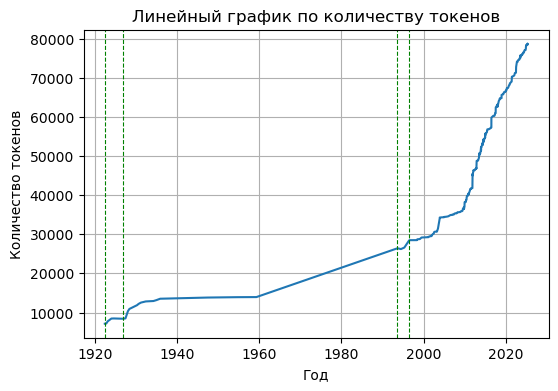

In [227]:
#даты для разделителей (показывает первые редакции документов)
divider_dates = ['1922-06-01', '1926-11-22', '1993-08-27', '1996-06-13']
divider_dates = pd.to_datetime(divider_dates)

plt.figure(figsize=(6, 4)) #задаем размер

#построение графика
plt.plot(df['Дата редакции'], df['Количество токенов'])

#добавляем вертикальные линии по выбранным датам
for date in divider_dates:
    plt.axvline(x=date, color='green', linestyle='--', linewidth=0.8)

#настройка подписей и заголовка
plt.xlabel('Год')
plt.ylabel('Количество токенов')
plt.title('Линейный график по количеству токенов')
plt.grid(True)

plt.show()

### График по метрикам TTR и MATTR

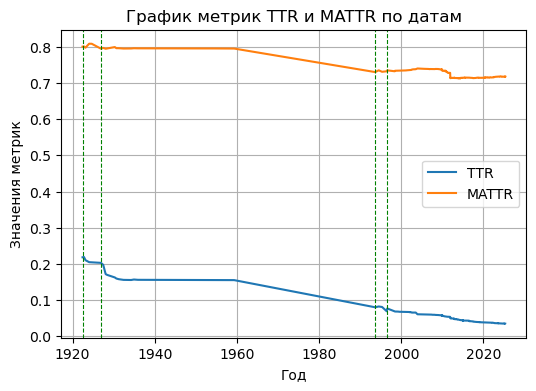

In [230]:
divider_dates = ['1922-06-01', '1926-11-22', '1993-08-27', '1996-06-13']
divider_dates = pd.to_datetime(divider_dates)

plt.figure(figsize=(6, 4))

plt.plot(df['Дата редакции'], df['TTR'], label='TTR')
plt.plot(df['Дата редакции'], df['MATTR'], label='MATTR')

plt.xlabel('Год')
plt.ylabel('Значения метрик')
plt.title('График метрик TTR и MATTR по датам')
plt.legend()
plt.grid(True)

for date in divider_dates:
    plt.axvline(x=date, color='green', linestyle='--', linewidth=0.8)

plt.show()

### График Readability (по Оборневой)

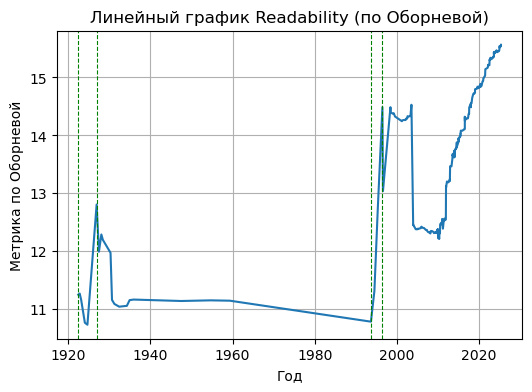

In [233]:
divider_dates = ['1922-06-01', '1926-11-22', '1993-08-27', '1996-06-13']
divider_dates = pd.to_datetime(divider_dates)

plt.figure(figsize=(6, 4))

plt.plot(df['Дата редакции'], df['oborneva'])

for date in divider_dates:
    plt.axvline(x=date, color='green', linestyle='--', linewidth=0.8)

plt.xlabel('Год')
plt.ylabel('Метрика по Оборневой')
plt.title('Линейный график Readability (по Оборневой)')
plt.grid(True)

plt.show()

### График Readability (по Мацковскому)

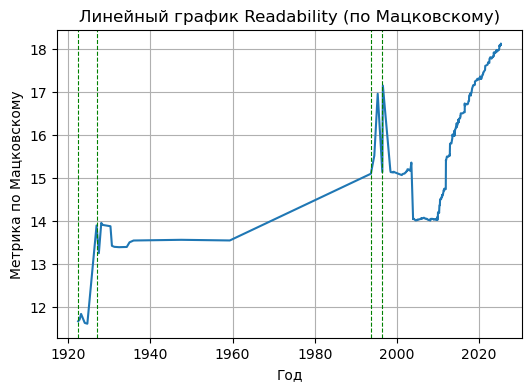

In [236]:
divider_dates = ['1922-06-01', '1926-11-22', '1993-08-27', '1996-06-13']
divider_dates = pd.to_datetime(divider_dates)

plt.figure(figsize=(6, 4))

plt.plot(df['Дата редакции'], df['matskovsky'])

for date in divider_dates:
    plt.axvline(x=date, color='green', linestyle='--', linewidth=0.8)

plt.xlabel('Год')
plt.ylabel('Метрика по Мацковскому')
plt.title('Линейный график Readability (по Мацковскому)')
plt.grid(True)

plt.show()

### График Readability (Flesh-Reading Ease)

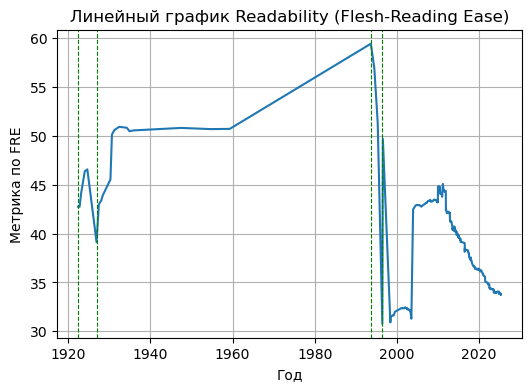

In [239]:
divider_dates = ['1922-06-01', '1926-11-22', '1993-08-27', '1996-06-13']
divider_dates = pd.to_datetime(divider_dates)

plt.figure(figsize=(6, 4))

plt.plot(df['Дата редакции'], df['FRE'])

for date in divider_dates:
    plt.axvline(x=date, color='green', linestyle='--', linewidth=0.8)

plt.xlabel('Год')
plt.ylabel('Метрика по FRE')
plt.title('Линейный график Readability (Flesh-Reading Ease)')
plt.grid(True)

plt.show()

### Облако слов (по наиболее частотным словам)

In [242]:
!pip install wordcloud

In [243]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

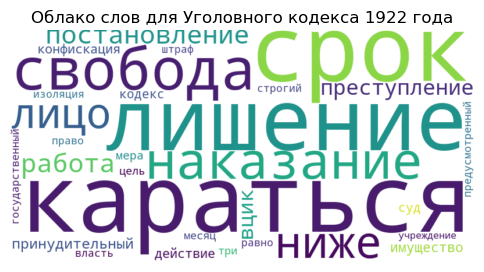

In [250]:
#Создаем облако слов для Уголовного кодекса 1922 года
#находим все строки с нужным названием файла
matching_rows = df[df['Название файла'] == 'Постановление ВЦИК от 01.06.1922 (ред. от 25.08.1924)  О вве.docx']

#достаем данные из списка частотных слов
freq_list = matching_rows.iloc[0]['30 высокочастотных лемм']

#преобразуем список кортежей в словарь
freq_dict = dict(freq_list)

#создаем облако слов из словаря
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для Уголовного кодекса 1922 года')
plt.show()

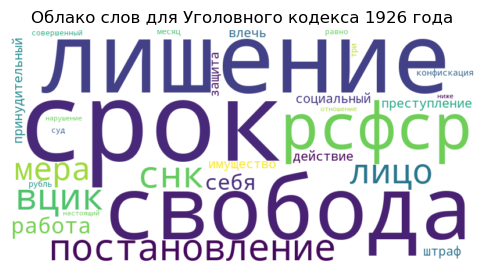

In [254]:
#Создаем облако слов для Уголовного кодекса 1926 года
matching_rows = df[df['Название файла'] == 'Постановление ВЦИК от 22.11.1926 (ред. от 27.04.1959)  О вве.docx']

freq_list = matching_rows.iloc[0]['30 высокочастотных лемм']

freq_dict = dict(freq_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для Уголовного кодекса 1926 года')
plt.show()

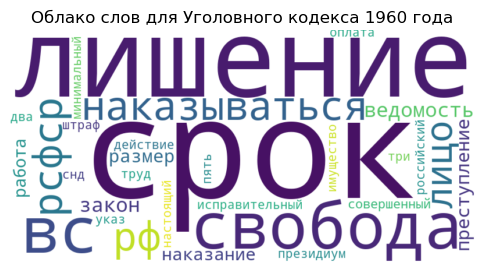

In [256]:
#Создаем облако слов для Уголовного кодекса 1960 года
matching_rows = df[df['Название файла'] == 'Уголовный кодекс РСФСР  (утв. ВС РСФСР 27.10.1960) (ред. от.docx']

freq_list = matching_rows.iloc[0]['30 высокочастотных лемм']

freq_dict = dict(freq_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для Уголовного кодекса 1960 года')
plt.show()

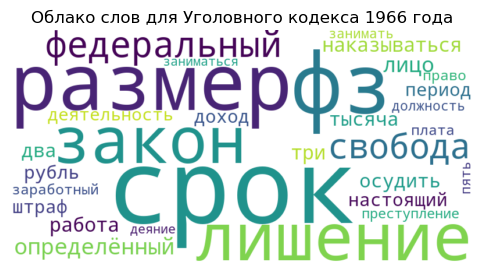

In [260]:
#Создаем облако слов для Уголовного кодекса 1966 года
matching_rows = df[df['Название файла'] == 'Уголовный кодекс Российской Федерации  от 13.06.1996 N 63-ФЗ.docx']

freq_list = matching_rows.iloc[0]['30 высокочастотных лемм']

freq_dict = dict(freq_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для Уголовного кодекса 1966 года')
plt.show()

### Облако слов (по наименее частотным словам)

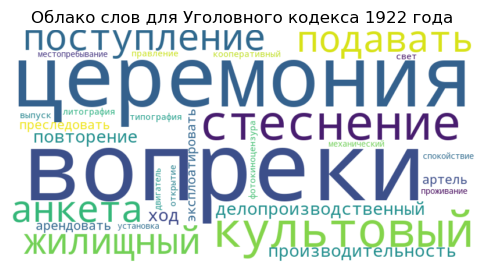

In [263]:
#Создаем облако слов для Уголовного кодекса 1922 года
matching_rows = df[df['Название файла'] == 'Постановление ВЦИК от 01.06.1922 (ред. от 25.08.1924)  О вве.docx']

freq_list = matching_rows.iloc[0]['30 низкочастотных лемм']

freq_dict = dict(freq_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для Уголовного кодекса 1922 года')
plt.show()

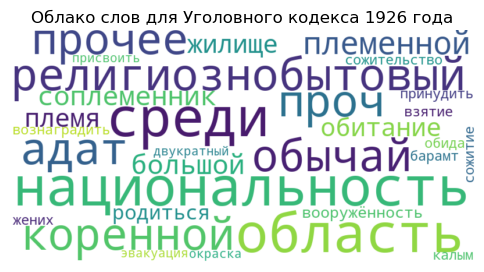

In [265]:
#Создаем облако слов для Уголовного кодекса 1926 года
matching_rows = df[df['Название файла'] == 'Постановление ВЦИК от 22.11.1926 (ред. от 27.04.1959)  О вве.docx']

freq_list = matching_rows.iloc[0]['30 низкочастотных лемм']

freq_dict = dict(freq_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для Уголовного кодекса 1926 года')
plt.show()

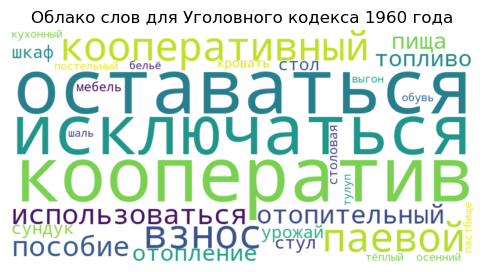

In [267]:
#Создаем облако слов для Уголовного кодекса 1960 года
matching_rows = df[df['Название файла'] == 'Уголовный кодекс РСФСР  (утв. ВС РСФСР 27.10.1960) (ред. от.docx']

freq_list = matching_rows.iloc[0]['30 низкочастотных лемм']

freq_dict = dict(freq_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для Уголовного кодекса 1960 года')
plt.show()

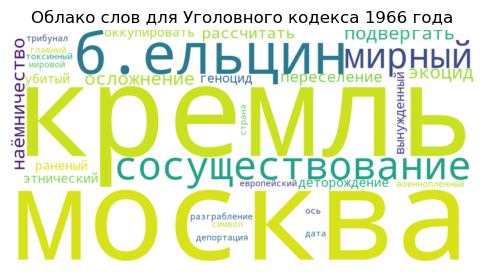

In [269]:
#Создаем облако слов для Уголовного кодекса 1966 года
matching_rows = df[df['Название файла'] == 'Уголовный кодекс Российской Федерации  от 13.06.1996 N 63-ФЗ.docx']

freq_list = matching_rows.iloc[0]['30 низкочастотных лемм']

freq_dict = dict(freq_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для Уголовного кодекса 1966 года')
plt.show()